# Training Pipeline: Multiple Cities with mu_factor

This notebook fits model parameters using all data from chosen cities with the unified mu_factor model.
The results are saved to `results_new_params_mu_factor.json` in the root directory.

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import lmfit
from PIL import Image
from scipy.special import erf
from scipy.stats import pearsonr
from scipy import optimize
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt

# Cities to train on
CITIES = ['Parnamirim', 'Santarem', 'CampoGrande']
# Cities to test on (not used during training)
TEST_CITIES = ['NovaIguacu', 'DuqueDeCaxias']
OUTPUT_FILE = 'results_new_params_mu_factor.json'

# City configuration: CSV path, map base path, neighborhood names (map folders), CSV column suffixes
CITY_CONFIG = {
    'Parnamirim': {
        'csv': 'data/Parnamirim.csv',
        'map_base': 'maps/Parnamirim_RN',
        'neighborhoods': ['Areia', 'Emaus', 'Liberdade'],
        'csv_suffixes': ['Areia', 'Emaus', 'Liberdade'],
    },
    'Santarem': {
        'csv': 'data/Santarem.csv',
        'map_base': 'maps/Santarem_PA',
        'neighborhoods': ['Jd_Santarem', 'Republica', 'Santarenzinho'],
        'csv_suffixes': ['Jd_Santarem', 'Republica', 'Santarenzinho'],
    },
    'CampoGrande': {
        'csv': 'data/CampoGrande.csv',
        'map_base': 'maps/CampoGrande_MS',
        'neighborhoods': ['Guanandi', 'Planalto', 'Carlota'],
        'csv_suffixes': ['Guanandi', 'Planalto', 'Carlota'],
    },
    'NovaIguacu': {
        'csv': 'data/NovaIguacu.csv',
        'map_base': 'maps/NovaIguacu_RJ',
        'neighborhoods': ['Cabucu', 'Ceramica', 'Moqueta'],
        'csv_suffixes': ['Cabu\u00e7u', 'Ceramica', 'Moqueta'],
    },
    'DuqueDeCaxias': {
        'csv': 'data/DuqueCaxias.csv',
        'map_base': 'maps/DuqueDeCaxias_RJ',
        'neighborhoods': ['Bilac', 'Primavera', 'Saracuruna'],
        'csv_suffixes': ['Bilac', 'Primavera', 'Saracuruna'],
    },
}

## 1. Helper Functions

In [19]:
def normal(R, mu, T):
    return np.exp(-(T - mu)**2 / (2 * R))

def plateau(R, mu, T):
    return np.exp(-(T - mu)**8 / (2 * R)**5)

def phi(P):
    return (erf((P - 10) / 40) + 0.3) / 1.2

def safe_pearsonr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return pearsonr(x, y)[0]

# Terrain classification from map images
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50: return True
    if g > 40 and g > r * 0.9 and g > b * 1.1: return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30: return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30: return True
    return False

def count_terrain(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    for x in range(0, width, 3):
        for y in range(0, height, 3):
            pm = roadmap.getpixel((x, y))[:3]
            ps = satellite.getpixel((x, y))[:3]
            if isWater(pm): water += 1
            elif isStreet(pm): streets += 1
            elif isGreen(ps): parks += 1
            else: houses += 1
    return [water, parks, streets, houses]

## 2. Data Loading
Load `dataNew.csv` from each training city folder and concatenate.

In [20]:
dfs = []
for city in CITIES:
    path = os.path.join(city, 'dataNew.csv')
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['City'] = city
        dfs.append(df)
    else:
        print(f"Warning: {path} not found.")

full_data = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(full_data)} rows from {len(dfs)} cities.")
full_data.head()

Loaded 76 rows from 3 cities.


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity,City
0,0,0.000000,0.000000,21.722921,0.030315,0.077917,0.000000,25.678571,0.000,Parnamirim
1,30,16.296291,26.752488,0.000000,0.008759,0.000000,0.000000,26.067262,21.150,Parnamirim
2,60,27.243784,38.929672,0.000000,0.000000,0.000000,0.145432,26.334524,20.675,Parnamirim
3,90,19.230432,80.667822,0.000000,0.006263,0.000168,0.120988,27.262738,14.725,Parnamirim
4,120,12.487652,52.309771,0.000000,0.022915,0.059390,0.000000,27.104762,20.775,Parnamirim


## 3. Model Definition
Unified mu_factor model: single temperature range for all mu parameters, with `mu_factor` controlling mortality scaling.

Training uses **OVT only** with `log1p` transform to handle different scales across cities.

In [21]:
def calculate_model(params, T_arr, P_arr):
    Tminmu = params["Tminmu"].value
    Tmaxmu = params["Tmaxmu"].value
    Tmingamma = params["Tmingamma"].value
    Tmaxgamma = params["Tmaxgamma"].value
    Tminr = params["Tminr"].value
    Tmaxr = params["Tmaxr"].value
    Tmink = params["Tmink"].value
    Tmaxk = params["Tmaxk"].value
    Tmine = params["Tmine"].value
    Tmaxe = params["Tmaxe"].value
    mu_factor = params["mu_factor"].value

    mu10, mu20, mu30 = 0.1170, 0.025, 0.01
    gamma0, r0, k0, e0 = 0.5596, 34, 89000, 0.24

    Mmu = (Tminmu + Tmaxmu) / 2
    Dmu = abs(Tmaxmu - Tminmu) / 2
    Mgamma = (Tmingamma + Tmaxgamma) / 2
    Dgamma = abs(Tmaxgamma - Tmingamma) / 2
    Mr = (Tminr + Tmaxr) / 2
    Dr = abs(Tmaxr - Tminr) / 2
    Mk = (Tmink + Tmaxk) / 2
    Dk = abs(Tmaxk - Tmink) / 2
    Me = (Tmine + Tmaxe) / 2
    De = abs(Tmaxe - Tmine) / 2

    mu1 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T_arr)) * mu10
    mu2 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T_arr)) * mu20
    mu3 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T_arr)) * mu30
    gamma = normal(Dgamma, Mgamma, T_arr) * gamma0
    r = phi(P_arr) * normal(Dr, Mr, T_arr) * r0
    k = phi(P_arr) * normal(Dk, Mk, T_arr) * k0
    e = e0 * normal(De, Me, T_arr) * phi(P_arr)

    denominator_q0 = mu1 * (mu2 + gamma) * (mu3 + e)
    Q0 = np.zeros_like(T_arr)
    valid_q0 = denominator_q0 != 0
    Q0[valid_q0] = (gamma[valid_q0] * e[valid_q0] * r[valid_q0]) / denominator_q0[valid_q0]

    eqADT = np.zeros_like(T_arr)
    eqOVT = np.zeros_like(T_arr)

    cond = Q0 > 1
    if np.any(cond):
        eqADT[cond] = k[cond] * (gamma[cond] / mu1[cond]) * (1 - 1 / Q0[cond])
        denom_ovt = mu1 * (mu3 + e)
        valid_ovt = (denom_ovt != 0) & cond
        eqOVT[valid_ovt] = k[valid_ovt] * (gamma[valid_ovt] * r[valid_ovt]) / denom_ovt[valid_ovt] * (1 - 1 / Q0[valid_ovt])

    return eqOVT, eqADT


def objective_function(params, category):
    ovt_col = f'OVT_{category}'

    T_arr = full_data['Temperature'].values
    P_arr = full_data['Pluviosity'].values
    ovt_obs = full_data[ovt_col].values

    ovt_pred, _ = calculate_model(params, T_arr, P_arr)

    # log1p transform to compress dynamic range across cities
    log_obs = np.log1p(ovt_obs)
    log_pred = np.log1p(ovt_pred)

    return log_obs - log_pred

## 4. Sensitivity Analysis & Parameter Setup

In [22]:
TMIN = 0
TMAX = 40

param_names = [
    "Tminmu", "fraction_mu",
    "Tmingamma", "fraction_gamma",
    "Tminr", "fraction_r",
    "Tmink", "fraction_k",
    "Tmine", "fraction_e",
    "mu_factor"
]

problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': [[TMIN, TMAX], [0.1, 1.0]] * 5 + [[1.0, 10.0]]
}


def sensitivity_wrapper(X):
    p = lmfit.Parameters()
    for name in param_names:
        p.add(name, value=0)
        if "fraction" in name:
            target_tmin = name.replace("fraction_", "Tmin")
            target_tmax = name.replace("fraction_", "Tmax")
            p.add(target_tmax, expr=f"{target_tmin} + {name} * ({TMAX} - {target_tmin})")

    T_sample = full_data['Temperature'].values
    P_sample = full_data['Pluviosity'].values
    out = np.zeros(X.shape[0])

    for i, x in enumerate(X):
        p["Tminmu"].value = x[0]
        p["fraction_mu"].value = x[1]
        p["Tmingamma"].value = x[2]
        p["fraction_gamma"].value = x[3]
        p["Tminr"].value = x[4]
        p["fraction_r"].value = x[5]
        p["Tmink"].value = x[6]
        p["fraction_k"].value = x[7]
        p["Tmine"].value = x[8]
        p["fraction_e"].value = x[9]
        p["mu_factor"].value = x[10]

        eqOVT, eqADT = calculate_model(p, T_sample, P_sample)
        out[i] = np.sum(np.concatenate([eqOVT, eqADT])**2)

    return out

In [23]:
def create_params(sensible_params):
    params = lmfit.Parameters()
    defaults = {
        "Tminmu": (TMIN + TMAX) / 2, "fraction_mu": 0.5,
        "Tmingamma": (TMIN + TMAX) / 2, "fraction_gamma": 0.5,
        "Tminr": (TMIN + TMAX) / 2, "fraction_r": 0.5,
        "Tmink": (TMIN + TMAX) / 2, "fraction_k": 0.5,
        "Tmine": (TMIN + TMAX) / 2, "fraction_e": 0.5,
        "mu_factor": 5.0
    }

    for name in param_names:
        val = defaults.get(name, (TMIN + TMAX) / 2)
        vary = name in sensible_params
        range_min = TMIN if "Tmin" in name else 0.1
        range_max = TMAX if "Tmin" in name else 1.0
        if name == "mu_factor":
            range_min = 1.0
            range_max = 10.0
        params.add(name, value=val, min=range_min, max=range_max, vary=vary)

    params.add("Tmaxmu", expr=f"Tminmu + fraction_mu * ({TMAX} - Tminmu)")
    params.add("Tmaxgamma", expr=f"Tmingamma + fraction_gamma * ({TMAX} - Tmingamma)")
    params.add("Tmaxr", expr=f"Tminr + fraction_r * ({TMAX} - Tminr)")
    params.add("Tmaxk", expr=f"Tmink + fraction_k * ({TMAX} - Tmink)")
    params.add("Tmaxe", expr=f"Tmine + fraction_e * ({TMAX} - Tmine)")

    return params

## 5. Main Training Loop

Performing Sensitivity Analysis...


/var/folders/_c/wqlz16pj5530wg9sb_zqc_lr0000gp/T/ipykernel_50223/2636658694.py:8: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024 * 8)
/opt/homebrew/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Sensible parameters: ['Tminr', 'fraction_gamma', 'Tmine', 'Tmink', 'Tmingamma', 'fraction_e', 'fraction_mu', 'fraction_k', 'fraction_r', 'Tminmu', 'mu_factor']
  Tminmu: ST = 0.2717
  fraction_mu: ST = 0.4170
  Tmingamma: ST = 0.5039
  fraction_gamma: ST = 0.6437
  Tminr: ST = 0.9173
  fraction_r: ST = 0.3308
  Tmink: ST = 0.5054
  fraction_k: ST = 0.3719
  Tmine: ST = 0.5863
  fraction_e: ST = 0.4318
  mu_factor: ST = 0.0474


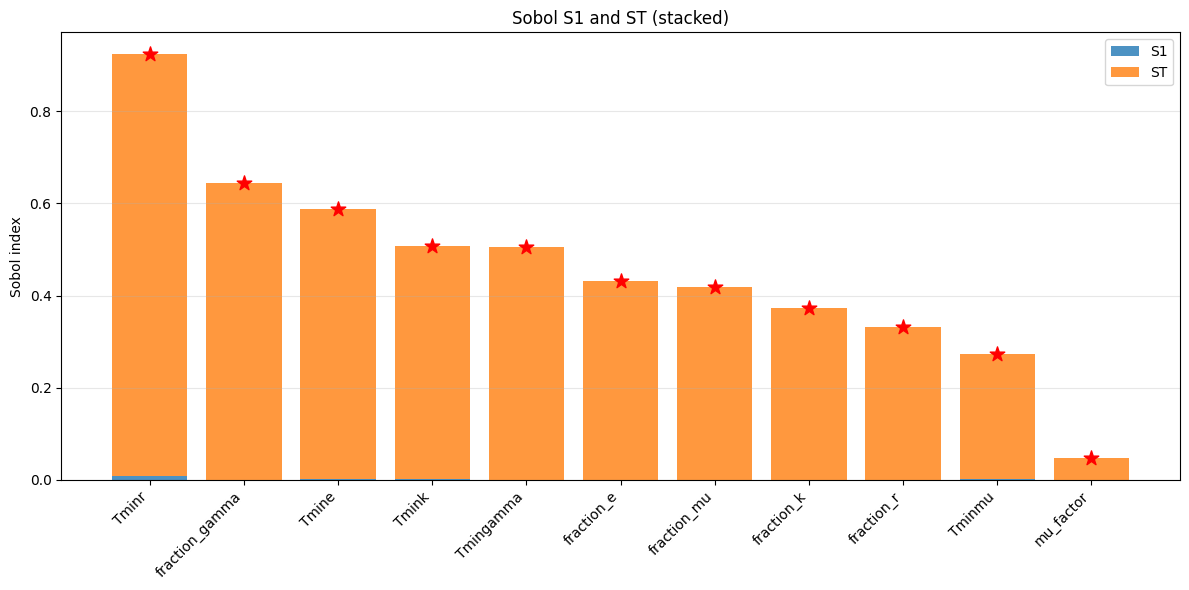

In [24]:
CATEGORIES = ['park', 'house', 'street']
final_results = {}

N_RUNS = 10

# Sensitivity Analysis
print("Performing Sensitivity Analysis...")
param_values = saltelli.sample(problem, 1024 * 8)
Y = sensitivity_wrapper(param_values)
Si = sobol.analyze(problem, Y, print_to_console=False)

st = np.asarray(Si['ST'])
st = np.where(np.isnan(st), 0.0, st)
order = np.argsort(st)[::-1]
total = st.sum()
cum = 0.0
sensible_params = []
for idx in order:
    if total == 0:
        break
    cum += st[idx]
    sensible_params.append(problem['names'][idx])
    if cum / total >= 1:
        break

print(f"Sensible parameters: {sensible_params}")
for i, name in enumerate(problem['names']):
    print(f"  {name}: ST = {st[i]:.4f}")

# Plot Sobol indices
s1 = np.asarray(Si['S1'])
s1 = np.where(np.isnan(s1), 0.0, s1)
names_arr = np.array(problem['names'])
sorted_names = names_arr[order]
st_sorted = st[order]
s1_sorted = s1[order]

x = np.arange(len(sorted_names))
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, s1_sorted, label='S1', color='tab:blue', alpha=0.8)
ax.bar(x, st_sorted, bottom=s1_sorted, label='ST', color='tab:orange', alpha=0.8)
sensible_set = set(sensible_params)
for i, name in enumerate(sorted_names):
    if name in sensible_set:
        ax.scatter(i, st_sorted[i] + s1_sorted[i], marker='*', s=120, color='red', zorder=3)
ax.set_xticks(x)
ax.set_xticklabels(sorted_names, rotation=45, ha='right')
ax.set_ylabel('Sobol index')
ax.set_title('Sobol S1 and ST (stacked)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

params = create_params(sensible_params)

In [25]:
for category in CATEGORIES:
    print(f"\n{'='*50}")
    print(f"Processing Category: {category}")
    print(f"{'='*50}")

    best_result = None
    best_chisqr = np.inf

    print(f"Starting optimization ({N_RUNS} runs)...")

    for i in range(N_RUNS):
        out = lmfit.minimize(
            objective_function,
            params,
            args=(category,),
            method='differential_evolution',
            max_nfev=20000,
            popsize=100,
            seed=i,
            tol=1e-7
        )

        out_final = lmfit.minimize(
            objective_function,
            out.params,
            args=(category,),
            method='leastsq',
            max_nfev=2000
        )

        print(f"Run {i:2d}: Chi2 = {out_final.chisqr:.4f}")
        if out_final.chisqr < best_chisqr:
            best_chisqr = out_final.chisqr
            best_result = out_final

    print(f"\n*** Best Chi2 for {category}: {best_chisqr:.4f} ***")

    cat_params = {}
    for name in best_result.params:
        cat_params[name] = best_result.params[name].value
    final_results[category] = cat_params

# Save Results
with open(OUTPUT_FILE, 'w') as f:
    json.dump(final_results, f, indent=4)

print(f"\n{'='*50}")
print(f"Saved fitting results to {OUTPUT_FILE}")
print(f"{'='*50}")


Processing Category: park
Starting optimization (10 runs)...
Run  0: Chi2 = 555.7025
Run  1: Chi2 = 549.8604
Run  2: Chi2 = 540.9578
Run  3: Chi2 = 992.7144
Run  4: Chi2 = 992.7144
Run  5: Chi2 = 992.7144
Run  6: Chi2 = 542.2567
Run  7: Chi2 = 992.7144
Run  8: Chi2 = 992.7144
Run  9: Chi2 = 548.1852

*** Best Chi2 for park: 540.9578 ***

Processing Category: house
Starting optimization (10 runs)...
Run  0: Chi2 = 357.4882
Run  1: Chi2 = 271.5875
Run  2: Chi2 = 226.0275
Run  3: Chi2 = 395.4267
Run  4: Chi2 = 395.4267
Run  5: Chi2 = 395.4267
Run  6: Chi2 = 395.4267
Run  7: Chi2 = 395.4267
Run  8: Chi2 = 395.4267
Run  9: Chi2 = 393.6915

*** Best Chi2 for house: 226.0275 ***

Processing Category: street
Starting optimization (10 runs)...
Run  0: Chi2 = 605.6575
Run  1: Chi2 = 721.3408
Run  2: Chi2 = 12332.7886
Run  3: Chi2 = 721.3408
Run  4: Chi2 = 482.2314
Run  5: Chi2 = 446.7243
Run  6: Chi2 = 661.8346
Run  7: Chi2 = 721.3408
Run  8: Chi2 = 721.3408
Run  9: Chi2 = 603.8438

*** Best Ch

In [26]:
# Verify Output
for cat in CATEGORIES:
    print(f"\n--- {cat} ---")
    print(json.dumps({k: round(v, 4) for k, v in final_results[cat].items()}, indent=2))


--- park ---
{
  "Tminmu": 33.9657,
  "fraction_mu": 0.9948,
  "Tmingamma": 22.8236,
  "fraction_gamma": 1.0,
  "Tminr": 21.0215,
  "fraction_r": 0.9121,
  "Tmink": 0.0,
  "fraction_k": 0.5194,
  "Tmine": 23.4604,
  "fraction_e": 0.1997,
  "mu_factor": 1.0,
  "Tmaxmu": 39.9687,
  "Tmaxgamma": 40.0,
  "Tmaxr": 38.3318,
  "Tmaxk": 20.7767,
  "Tmaxe": 26.7627
}

--- house ---
{
  "Tminmu": 23.2765,
  "fraction_mu": 0.3241,
  "Tmingamma": 27.167,
  "fraction_gamma": 0.6734,
  "Tminr": 17.9677,
  "fraction_r": 1.0,
  "Tmink": 0.0,
  "fraction_k": 0.5182,
  "Tmine": 25.3181,
  "fraction_e": 0.1,
  "mu_factor": 10.0,
  "Tmaxmu": 28.6966,
  "Tmaxgamma": 35.8089,
  "Tmaxr": 39.9994,
  "Tmaxk": 20.7296,
  "Tmaxe": 26.7863
}

--- street ---
{
  "Tminmu": 25.6873,
  "fraction_mu": 0.1162,
  "Tmingamma": 17.3302,
  "fraction_gamma": 0.9432,
  "Tminr": 8.8958,
  "fraction_r": 1.0,
  "Tmink": 0.0,
  "fraction_k": 0.4258,
  "Tmine": 17.9655,
  "fraction_e": 0.2955,
  "mu_factor": 3.9789,
  "Tmaxmu": 

## 6. Parameter Visualization

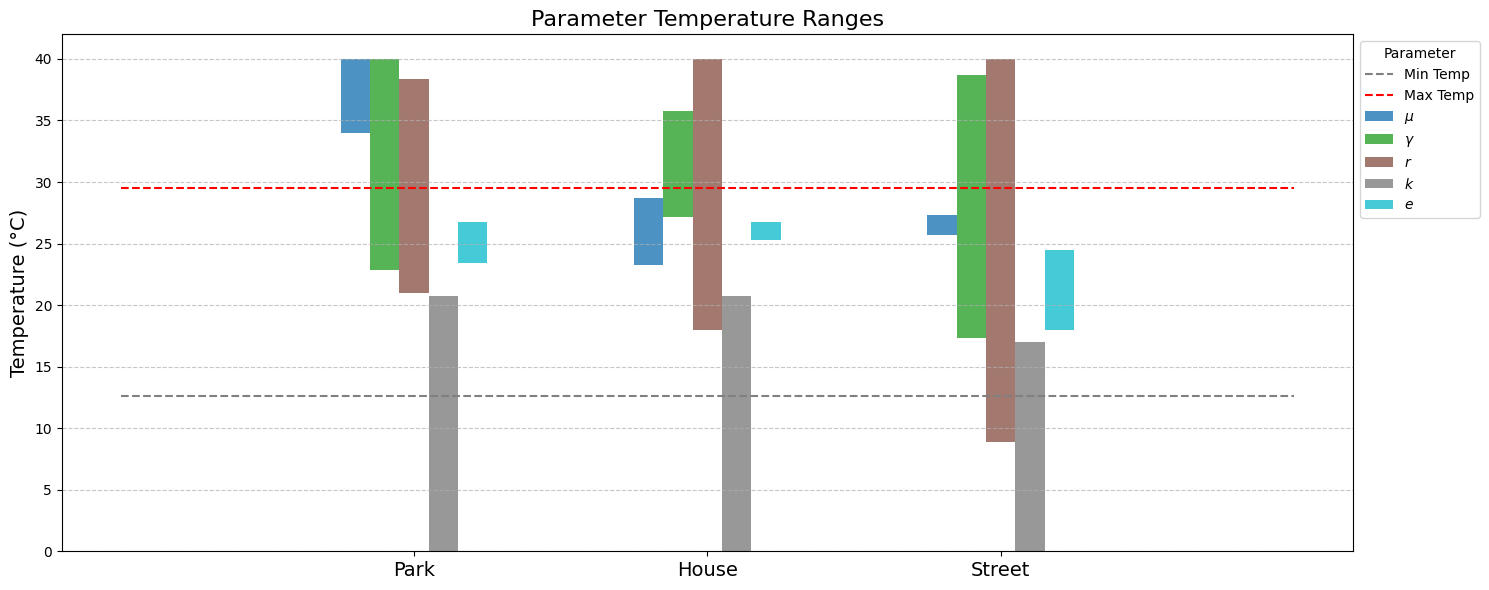

mu_factor[park] = 1.0000
mu_factor[house] = 10.0000
mu_factor[street] = 3.9789


In [27]:
parameters_map = {
    'mu': '$\\mu$',
    'gamma': '$\\gamma$',
    'r': '$r$',
    'k': '$k$',
    'e': '$e$'
}
categories_keys = ['park', 'house', 'street']
categories_labels = ['Park', 'House', 'Street']

fig, ax = plt.subplots(figsize=(15, 6))

bar_width = 0.1
index = np.arange(len(categories_keys))
opacity = 0.8

ax.hlines(full_data['Temperature'].min(), -1, len(categories_keys),
          colors='gray', linestyles='dashed', label='Min Temp')
ax.hlines(full_data['Temperature'].max(), -1, len(categories_keys),
          colors='red', linestyles='dashed', label='Max Temp')

colors = plt.cm.tab10(np.linspace(0, 1, len(parameters_map)))

for i, (param_suffix, param_label) in enumerate(parameters_map.items()):
    tmin_vals = []
    heights = []
    for cat in categories_keys:
        if cat in final_results:
            p = final_results[cat]
            tmin_key = f'Tmin{param_suffix}'
            tmax_key = f'Tmax{param_suffix}'
            tmin = p.get(tmin_key, 0)
            tmax = p.get(tmax_key, 0)
            tmin_vals.append(tmin)
            heights.append(tmax - tmin)
        else:
            tmin_vals.append(0)
            heights.append(0)
    x = index + i * bar_width - (len(parameters_map) * bar_width / 2) + bar_width / 2
    ax.bar(x, heights, bar_width, bottom=tmin_vals,
           alpha=opacity, color=colors[i], label=param_label)

ax.set_ylabel('Temperature (\u00b0C)', fontsize=14)
ax.set_xticks(index)
ax.set_xticklabels(categories_labels, fontsize=14)
ax.legend(title='Parameter', bbox_to_anchor=(1.0, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Parameter Temperature Ranges', fontsize=16)
plt.tight_layout()
plt.show()

for cat in categories_keys:
    print(f"mu_factor[{cat}] = {final_results[cat]['mu_factor']:.4f}")

## 7. Visualization: Trained Cities (terrain level)
Apply the fitted model to each training city individually and compare predicted vs observed.

In [28]:
def compute_equilibria(params_dict, T_arr, P_arr):
    """Vectorized version of compute_equilibria using T and P arrays directly."""
    Tminmu, Tmaxmu = params_dict["Tminmu"], params_dict["Tmaxmu"]
    Tmingamma, Tmaxgamma = params_dict["Tmingamma"], params_dict["Tmaxgamma"]
    Tminr, Tmaxr = params_dict["Tminr"], params_dict["Tmaxr"]
    Tmink, Tmaxk = params_dict["Tmink"], params_dict["Tmaxk"]
    Tmine, Tmaxe = params_dict["Tmine"], params_dict["Tmaxe"]
    mu_factor = params_dict["mu_factor"]

    mu10, mu20, mu30 = 0.1170, 0.025, 0.01
    gamma0, r0, k0, e0 = 0.5596, 34, 89000, 0.24

    T = np.asarray(T_arr, dtype=float)
    P = np.asarray(P_arr, dtype=float)

    Mmu, Dmu = (Tminmu + Tmaxmu) / 2, abs(Tmaxmu - Tminmu) / 2
    Mgamma, Dgamma = (Tmingamma + Tmaxgamma) / 2, abs(Tmaxgamma - Tmingamma) / 2
    Mr, Dr = (Tminr + Tmaxr) / 2, abs(Tmaxr - Tminr) / 2
    Mk, Dk = (Tmink + Tmaxk) / 2, abs(Tmaxk - Tmink) / 2
    Me, De = (Tmine + Tmaxe) / 2, abs(Tmaxe - Tmine) / 2

    mu1 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T)) * mu10
    mu2 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T)) * mu20
    mu3 = (mu_factor - (mu_factor - 1) * plateau(Dmu, Mmu, T)) * mu30
    gamma = normal(Dgamma, Mgamma, T) * gamma0
    r = phi(P) * normal(Dr, Mr, T) * r0
    k = phi(P) * normal(Dk, Mk, T) * k0
    e = e0 * normal(De, Me, T) * phi(P)

    denom = mu1 * (mu2 + gamma) * (mu3 + e)
    Q0 = np.zeros_like(T)
    valid = denom != 0
    Q0[valid] = (gamma[valid] * e[valid] * r[valid]) / denom[valid]

    eqADT = np.zeros_like(T)
    eqOVT = np.zeros_like(T)
    cond = Q0 > 1
    if np.any(cond):
        eqADT[cond] = k[cond] * (gamma[cond] / mu1[cond]) * (1 - 1 / Q0[cond])
        denom2 = mu1 * (mu3 + e)
        valid2 = (denom2 != 0) & cond
        eqOVT[valid2] = k[valid2] * (gamma[valid2] * r[valid2]) / denom2[valid2] * (1 - 1 / Q0[valid2])

    return eqOVT, eqADT

In [29]:
# Per-city predictions for trained cities
city_results = {}

for city in CITIES:
    city_df = full_data[full_data['City'] == city].copy()
    T_arr = city_df['Temperature'].values
    P_arr = city_df['Pluviosity'].values
    days = city_df['Day'].values

    city_preds = {}
    for cat in CATEGORIES:
        ovt_pred, adt_pred = compute_equilibria(final_results[cat], T_arr, P_arr)
        city_preds[cat] = {
            'ovt_pred': ovt_pred,
            'adt_pred': adt_pred,
            'ovt_obs': city_df[f'OVT_{cat}'].values,
            'adt_obs': city_df[f'ADT_{cat}'].values,
        }
    city_results[city] = {'days': days, 'preds': city_preds}

print("Predictions computed for all trained cities.")

Predictions computed for all trained cities.


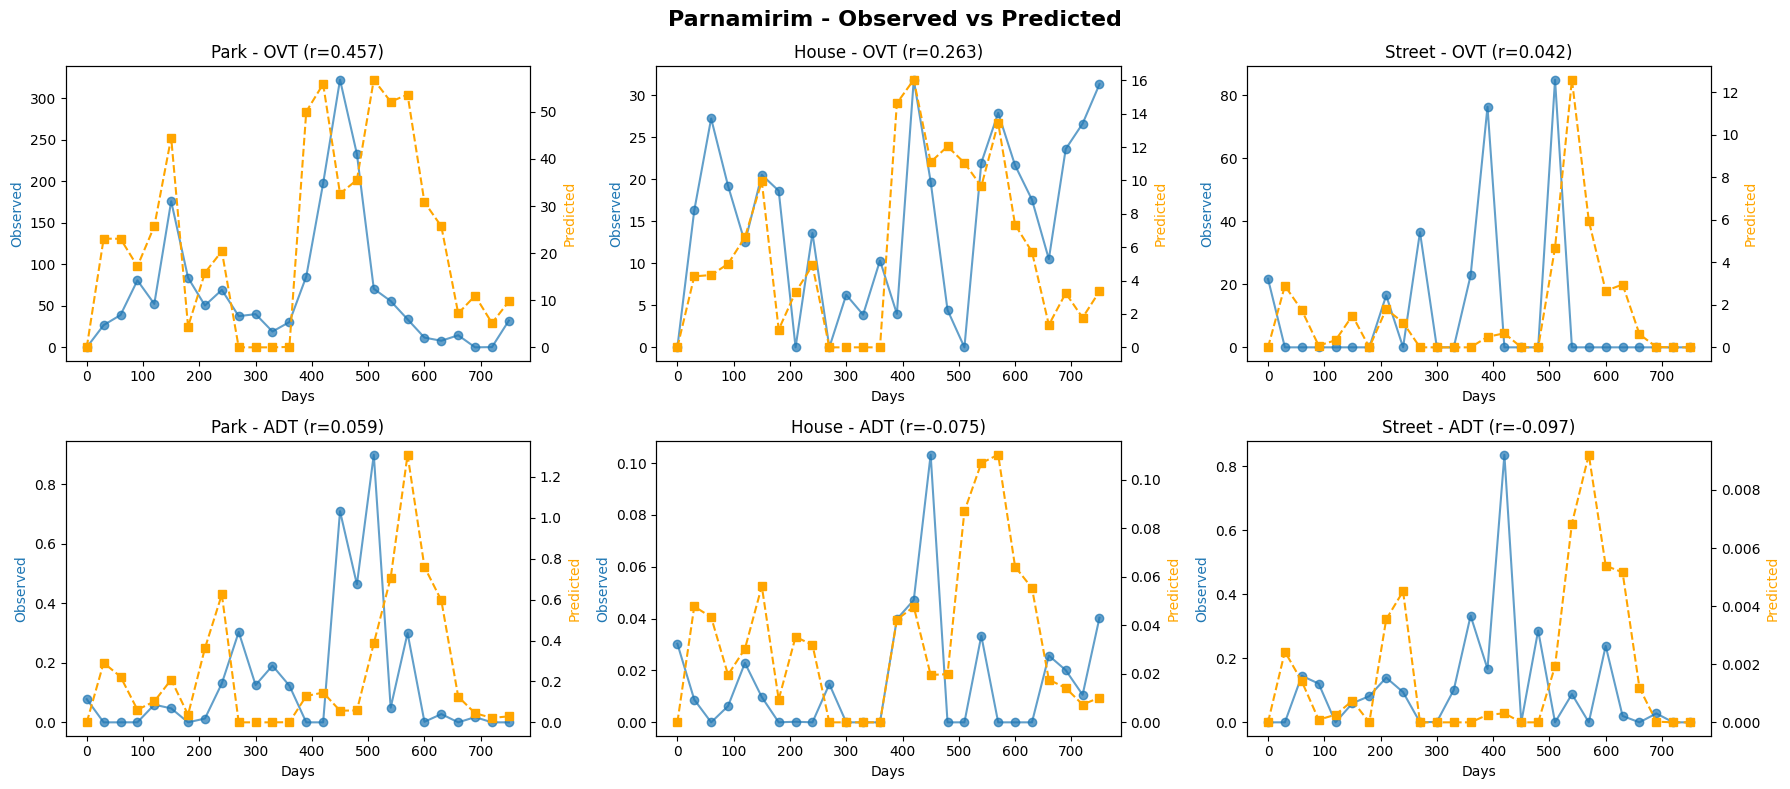

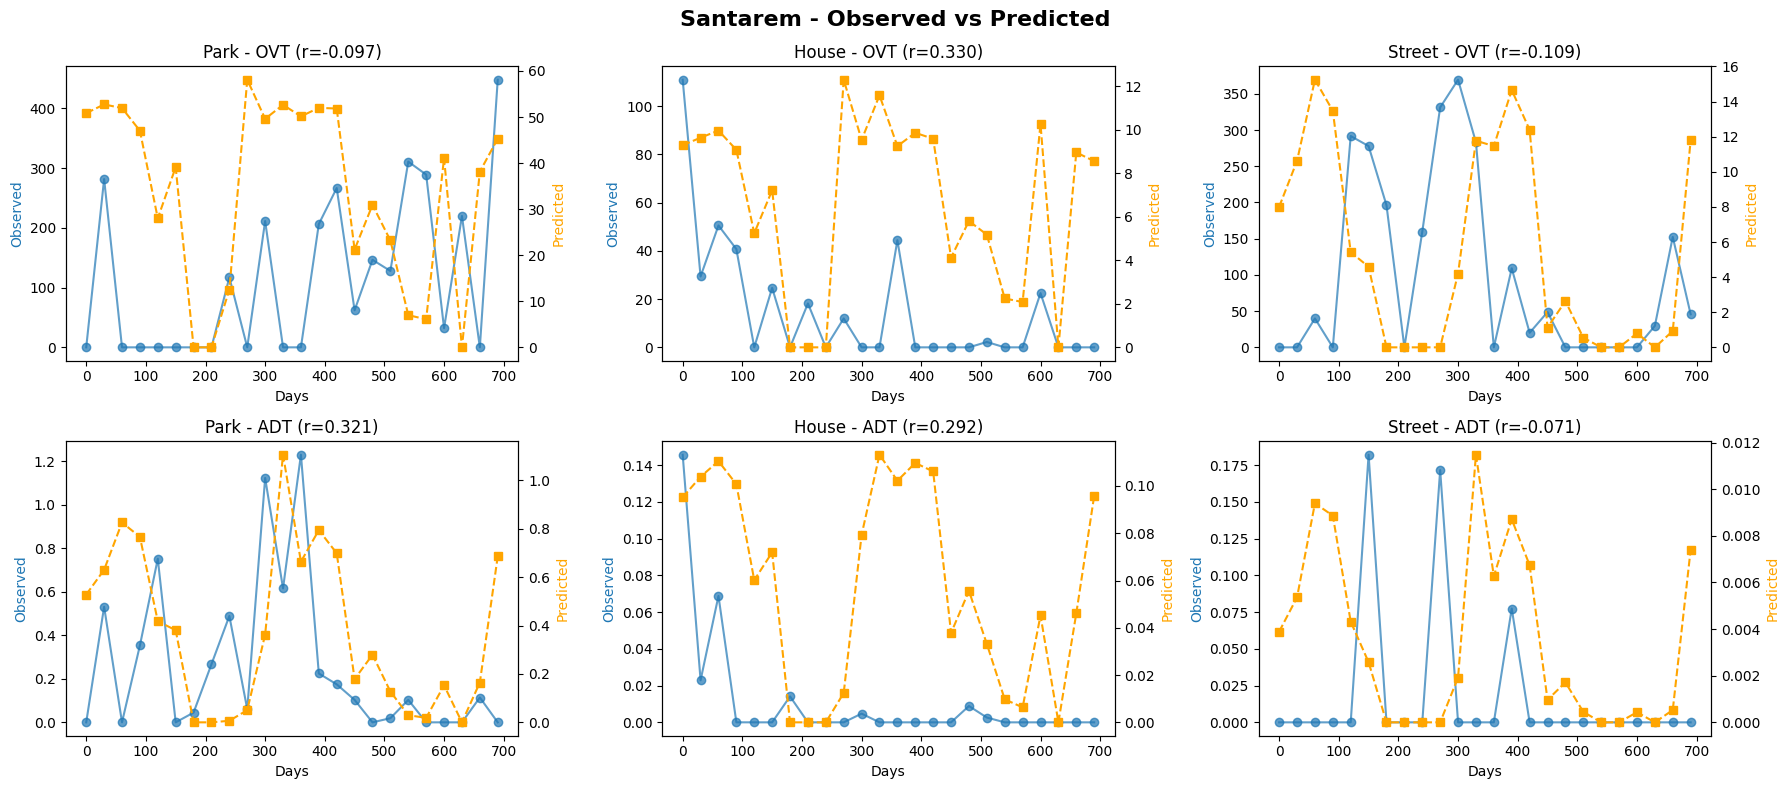

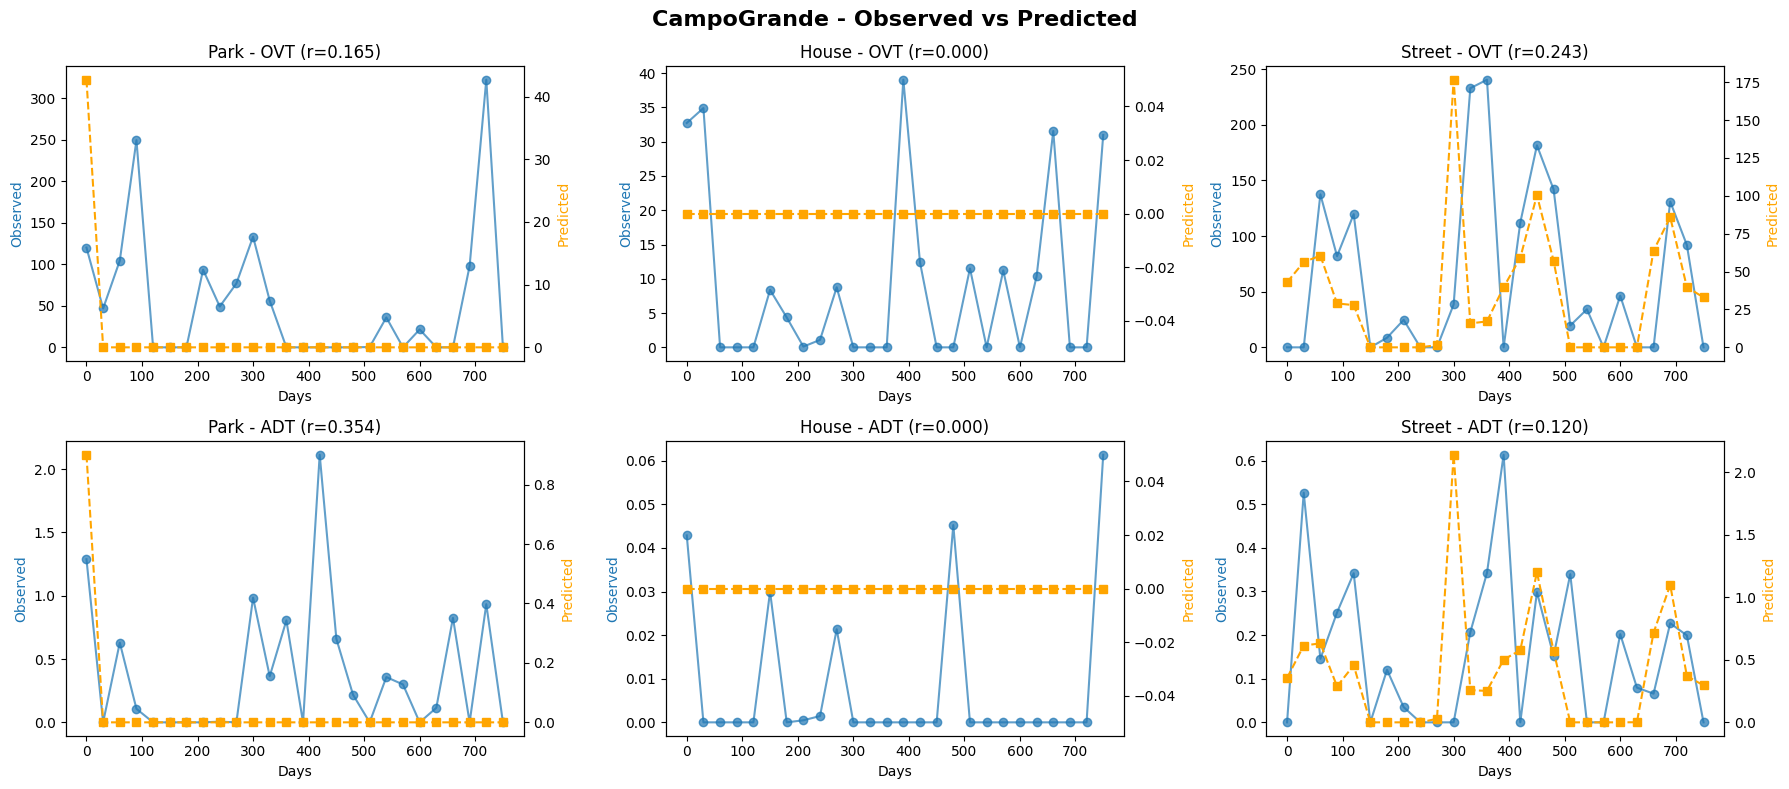

In [30]:
# Plot per-city terrain comparisons (OVT and ADT)
for city in CITIES:
    days = city_results[city]['days']
    preds = city_results[city]['preds']

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle(f'{city} - Observed vs Predicted', fontsize=16, fontweight='bold')

    for j, cat in enumerate(CATEGORIES):
        d = preds[cat]

        # OVT
        ax = axes[0, j]
        ax.plot(days, d['ovt_obs'], 'o-', label='Observed', alpha=0.7)
        ax2 = ax.twinx()
        ax2.plot(days, d['ovt_pred'], 's--', color='orange', label='Predicted')
        corr = safe_pearsonr(d['ovt_obs'], d['ovt_pred'])
        ax.set_title(f'{cat.capitalize()} - OVT (r={corr:.3f})')
        ax.set_xlabel('Days')
        ax.set_ylabel('Observed', color='tab:blue')
        ax2.set_ylabel('Predicted', color='orange')

        # ADT
        ax = axes[1, j]
        ax.plot(days, d['adt_obs'], 'o-', label='Observed', alpha=0.7)
        ax2 = ax.twinx()
        ax2.plot(days, d['adt_pred'], 's--', color='orange', label='Predicted')
        corr = safe_pearsonr(d['adt_obs'], d['adt_pred'])
        ax.set_title(f'{cat.capitalize()} - ADT (r={corr:.3f})')
        ax.set_xlabel('Days')
        ax.set_ylabel('Observed', color='tab:blue')
        ax2.set_ylabel('Predicted', color='orange')

    plt.tight_layout()
    plt.show()

In [31]:
# Correlation summary for trained cities
print("=" * 70)
print("SUMMARY: Pearson Correlations on Trained Cities (terrain level)")
print("=" * 70)

rows = []
for city in CITIES:
    preds = city_results[city]['preds']
    for cat in CATEGORIES:
        d = preds[cat]
        corr_ovt = safe_pearsonr(d['ovt_obs'], d['ovt_pred'])
        corr_adt = safe_pearsonr(d['adt_obs'], d['adt_pred'])
        rows.append({'City': city, 'Terrain': cat, 'OVT_r': corr_ovt, 'ADT_r': corr_adt})

summary_df = pd.DataFrame(rows)
print(summary_df.to_string(index=False, float_format='%.3f'))

print(f"\nAverage OVT r: {summary_df['OVT_r'].mean():.3f}")
print(f"Average ADT r: {summary_df['ADT_r'].mean():.3f}")

SUMMARY: Pearson Correlations on Trained Cities (terrain level)
       City Terrain  OVT_r  ADT_r
 Parnamirim    park  0.457  0.059
 Parnamirim   house  0.263 -0.075
 Parnamirim  street  0.042 -0.097
   Santarem    park -0.097  0.321
   Santarem   house  0.330  0.292
   Santarem  street -0.109 -0.071
CampoGrande    park  0.165  0.354
CampoGrande   house  0.000  0.000
CampoGrande  street  0.243  0.120

Average OVT r: 0.144
Average ADT r: 0.100


## 8. Neighborhood Reconstruction (trained cities)
For each city, compute terrain proportions from maps, then reconstruct neighborhood-level
predictions by combining terrain predictions with the proportion matrix.

In [32]:
def get_proportions_matrix(city_name):
    """Compute terrain proportion matrix for all neighborhoods of a city."""
    cfg = CITY_CONFIG[city_name]
    map_base = cfg['map_base']
    neighborhoods = cfg['neighborhoods']

    proportions_raw = []
    for n in neighborhoods:
        roadmap_path = f'{map_base}/{n}/roadmap.png'
        satellite_path = f'{map_base}/{n}/satellite.png'
        counts = count_terrain(roadmap_path, satellite_path)
        proportions_raw.append(counts)
        print(f'  {n}: {counts}')

    proportions = [np.array(c) / sum(c) for c in proportions_raw]
    return np.array(proportions)


def reconstruct_neighborhoods(city_name, pred_park, pred_house, pred_street, prop_matrix):
    """Reconstruct neighborhood-level predictions from terrain predictions."""
    cfg = CITY_CONFIG[city_name]
    n_neighborhoods = len(cfg['neighborhoods'])
    n_times = len(pred_park)

    # terrain order: [water, park, street, house]
    reconstructed = {}
    for var_name, park_arr, house_arr, street_arr in [
        ('OVT', pred_park, pred_house, pred_street),
    ]:
        preds = np.zeros((n_neighborhoods, n_times))
        for t in range(n_times):
            terrain_vec = [0, park_arr[t], street_arr[t], house_arr[t]]
            combined = prop_matrix @ terrain_vec
            for i in range(n_neighborhoods):
                preds[i, t] = combined[i]
        reconstructed[var_name] = preds

    return reconstructed


Neighborhood Reconstruction: Parnamirim
Computing terrain proportions...
  Areia: [0, 12836, 31489, 138004]
  Emaus: [0, 12243, 36715, 133371]
  Liberdade: [0, 47996, 22599, 111734]
Proportions matrix shape: (3, 4)


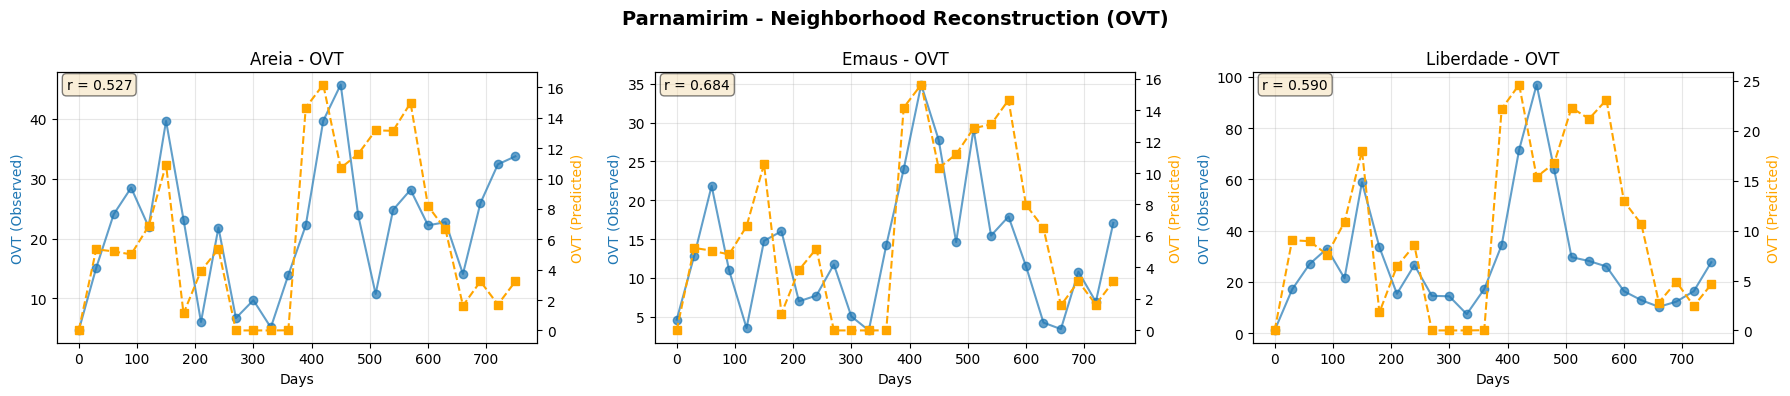

  Areia: Pearson r = 0.527
  Emaus: Pearson r = 0.684
  Liberdade: Pearson r = 0.590
  Average: 0.600

Neighborhood Reconstruction: Santarem
Computing terrain proportions...
  Jd_Santarem: [0, 8965, 29556, 143808]
  Republica: [0, 16593, 28935, 136801]
  Santarenzinho: [0, 13409, 26506, 142414]
Proportions matrix shape: (3, 4)


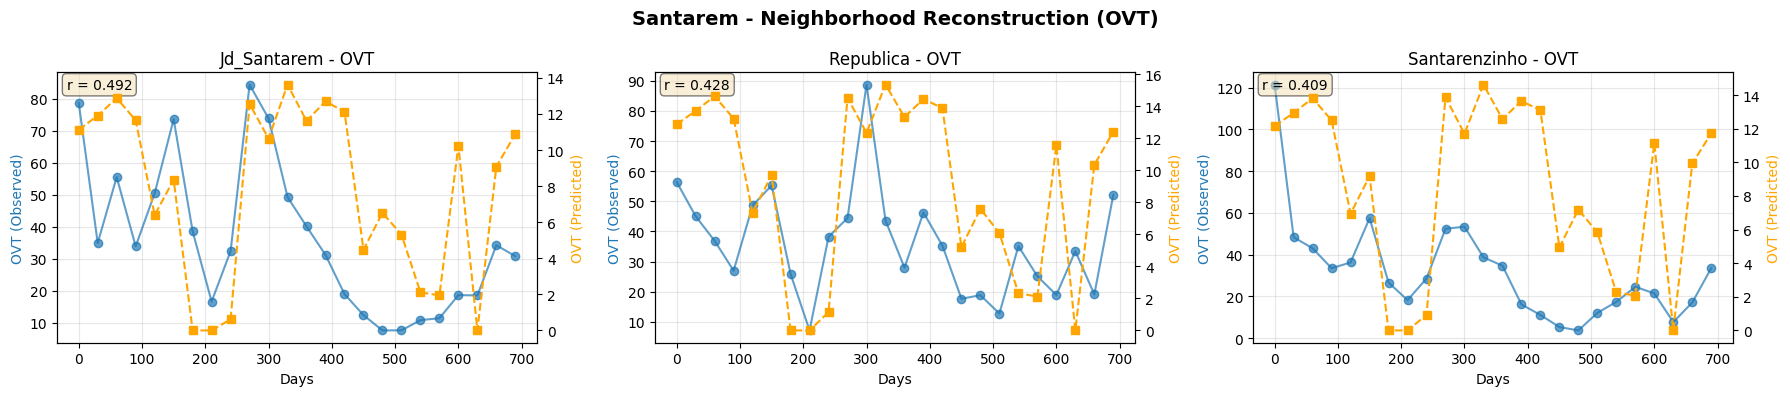

  Jd_Santarem: Pearson r = 0.492
  Republica: Pearson r = 0.428
  Santarenzinho: Pearson r = 0.409
  Average: 0.443

Neighborhood Reconstruction: CampoGrande
Computing terrain proportions...
  Guanandi: [0, 2686, 28827, 150816]
  Planalto: [0, 12800, 28385, 141144]
  Carlota: [0, 8235, 27088, 147006]
Proportions matrix shape: (3, 4)


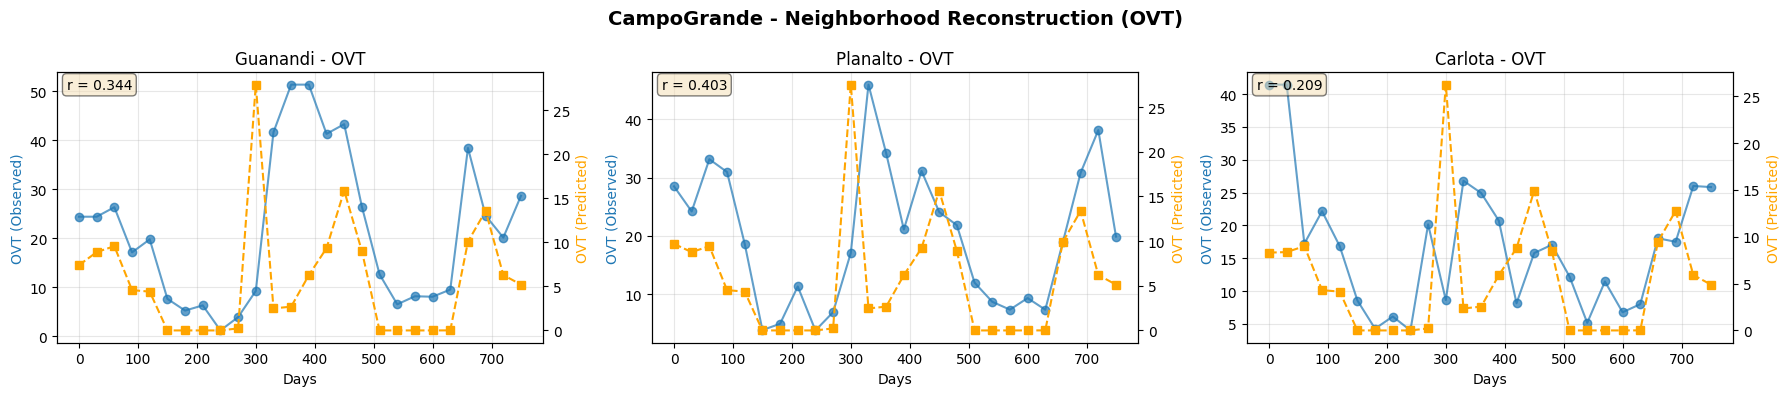

  Guanandi: Pearson r = 0.344
  Planalto: Pearson r = 0.403
  Carlota: Pearson r = 0.209
  Average: 0.318


In [33]:
# Neighborhood reconstruction for trained cities
train_neigh_results = {}

for city in CITIES:
    print(f"\n{'='*50}")
    print(f"Neighborhood Reconstruction: {city}")
    print(f"{'='*50}")

    cfg = CITY_CONFIG[city]
    csv_suffixes = cfg['csv_suffixes']
    neigh_names = cfg['neighborhoods']

    # Load raw neighborhood data
    df_raw = pd.read_csv(cfg['csv'])
    days_city = [i * 30 for i in range(len(df_raw))]

    # Compute terrain proportions
    print("Computing terrain proportions...")
    prop_matrix = get_proportions_matrix(city)
    print(f"Proportions matrix shape: {prop_matrix.shape}")

    # Get terrain-level predictions for this city
    cr = city_results[city]
    pred_park_ovt = cr['preds']['park']['ovt_pred']
    pred_house_ovt = cr['preds']['house']['ovt_pred']
    pred_street_ovt = cr['preds']['street']['ovt_pred']

    # Reconstruct
    reconstructed = reconstruct_neighborhoods(
        city, pred_park_ovt, pred_house_ovt, pred_street_ovt, prop_matrix
    )

    # Load observed neighborhood data
    obs_ovt = {}
    for i, (neigh, suffix) in enumerate(zip(neigh_names, csv_suffixes)):
        col = f'OVT_{suffix}'
        obs_ovt[neigh] = df_raw[col].ffill().bfill().values

    # Plot
    n_neigh = len(neigh_names)
    fig, axes = plt.subplots(1, n_neigh, figsize=(6 * n_neigh, 4))
    if n_neigh == 1:
        axes = [axes]

    corrs = []
    for i, neigh in enumerate(neigh_names):
        ax1 = axes[i]
        obs = obs_ovt[neigh]
        pred = reconstructed['OVT'][i]
        corr = safe_pearsonr(obs, pred)
        corrs.append(corr)

        ax1.plot(days_city, obs, 'o-', label='Observed', alpha=0.7)
        ax1.set_xlabel('Days')
        ax1.set_ylabel('OVT (Observed)', color='tab:blue')
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(days_city, pred, 's--', color='orange', label='Predicted')
        ax2.set_ylabel('OVT (Predicted)', color='orange')

        ax1.set_title(f'{neigh} - OVT')
        ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    fig.suptitle(f'{city} - Neighborhood Reconstruction (OVT)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print correlations
    for neigh, corr in zip(neigh_names, corrs):
        print(f'  {neigh}: Pearson r = {corr:.3f}')
    print(f'  Average: {np.mean(corrs):.3f}')

    train_neigh_results[city] = {
        'neighborhoods': neigh_names,
        'corrs': corrs,
        'prop_matrix': prop_matrix,
    }

In [34]:
# Summary table for neighborhood reconstruction (trained cities)
print("=" * 70)
print("SUMMARY: Neighborhood Reconstruction Pearson r (Trained Cities)")
print("=" * 70)

neigh_rows = []
for city in CITIES:
    res = train_neigh_results[city]
    for neigh, corr in zip(res['neighborhoods'], res['corrs']):
        neigh_rows.append({'City': city, 'Neighborhood': neigh, 'OVT_r': corr})

neigh_df = pd.DataFrame(neigh_rows)
print(neigh_df.to_string(index=False, float_format='%.3f'))
print(f"\nOverall average OVT r: {neigh_df['OVT_r'].mean():.3f}")

SUMMARY: Neighborhood Reconstruction Pearson r (Trained Cities)
       City  Neighborhood  OVT_r
 Parnamirim         Areia  0.527
 Parnamirim         Emaus  0.684
 Parnamirim     Liberdade  0.590
   Santarem   Jd_Santarem  0.492
   Santarem     Republica  0.428
   Santarem Santarenzinho  0.409
CampoGrande      Guanandi  0.344
CampoGrande      Planalto  0.403
CampoGrande       Carlota  0.209

Overall average OVT r: 0.454


## 9. Testing on Non-Trained Cities (terrain level)
Apply the fitted parameters to NovaIguacu and DuqueDeCaxias (cities not seen during training).

In [35]:
# Load test city data
test_dfs = {}
for city in TEST_CITIES:
    path = os.path.join(city, 'dataNew.csv')
    if os.path.exists(path):
        test_dfs[city] = pd.read_csv(path)
        print(f"Loaded {city}: {len(test_dfs[city])} rows")
    else:
        print(f"Warning: {path} not found.")

# Compute predictions for test cities
test_results = {}
for city, df in test_dfs.items():
    T_arr = df['Temperature'].values
    P_arr = df['Pluviosity'].values
    days = df['Day'].values

    city_preds = {}
    for cat in CATEGORIES:
        ovt_pred, adt_pred = compute_equilibria(final_results[cat], T_arr, P_arr)
        city_preds[cat] = {
            'ovt_pred': ovt_pred,
            'adt_pred': adt_pred,
            'ovt_obs': df[f'OVT_{cat}'].values,
            'adt_obs': df[f'ADT_{cat}'].values,
        }
    test_results[city] = {'days': days, 'preds': city_preds}

print("\nPredictions computed for test cities.")

Loaded NovaIguacu: 12 rows
Loaded DuqueDeCaxias: 12 rows

Predictions computed for test cities.


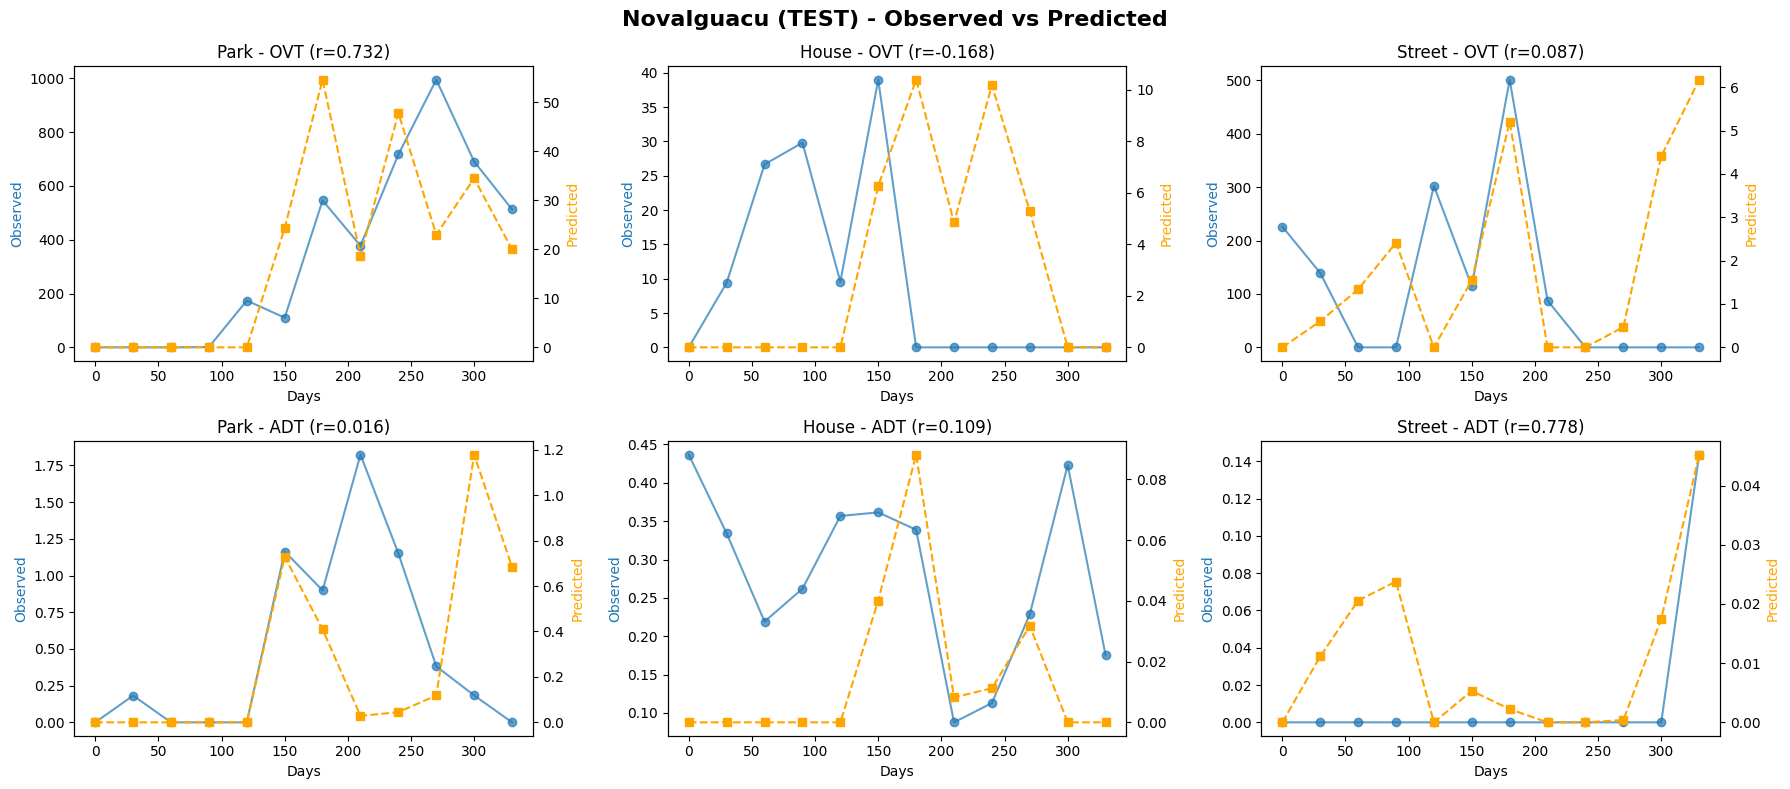

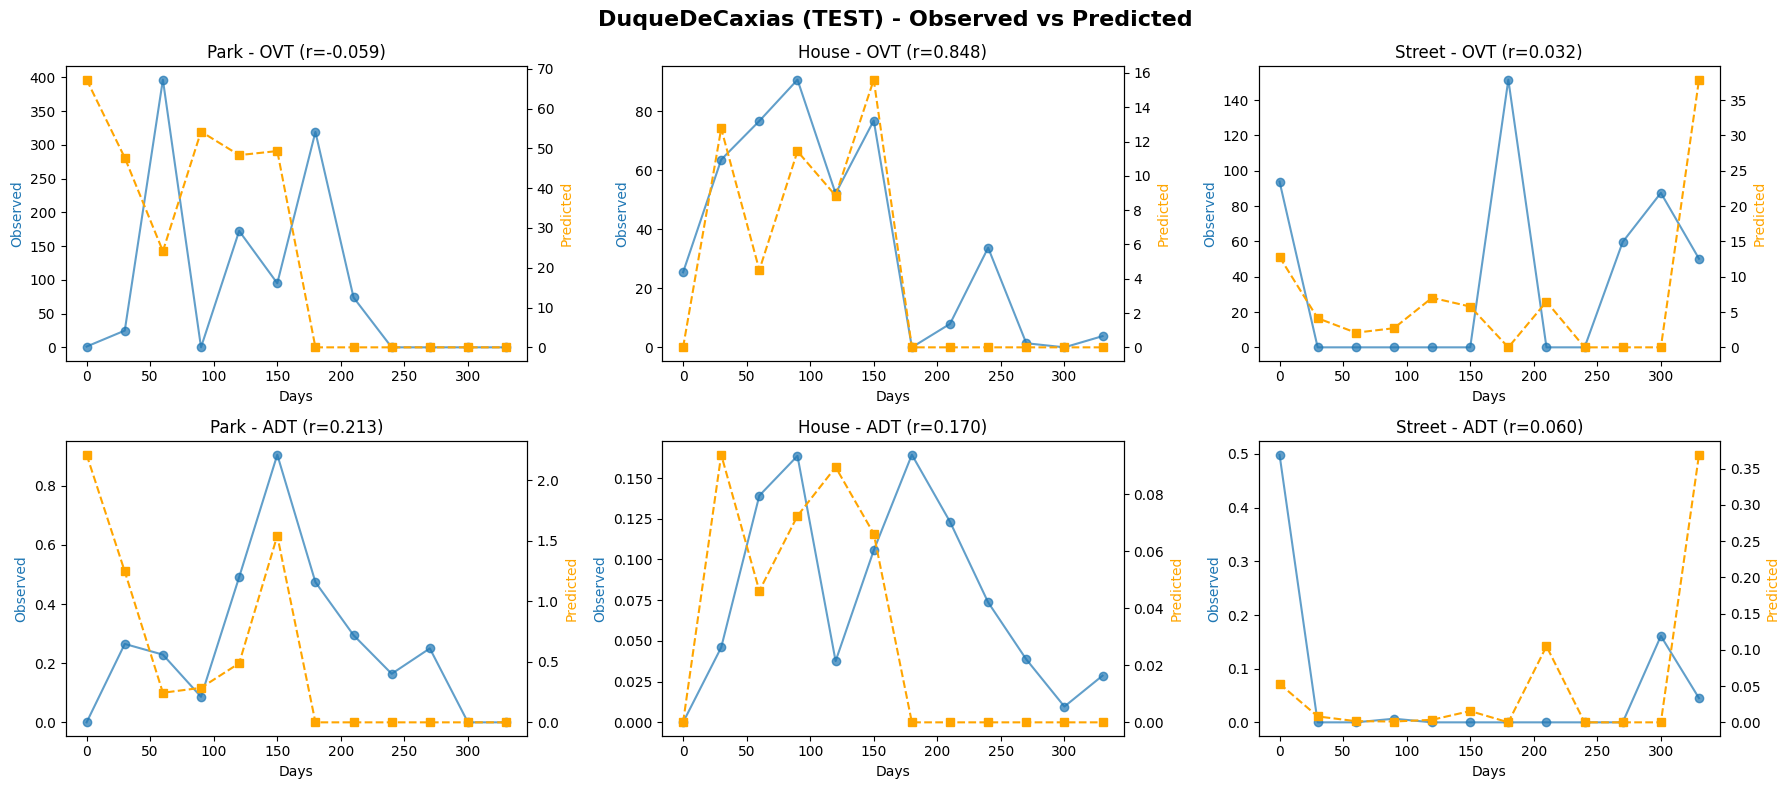

In [36]:
# Plot test city results (terrain level)
for city in TEST_CITIES:
    if city not in test_results:
        continue
    days = test_results[city]['days']
    preds = test_results[city]['preds']

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    fig.suptitle(f'{city} (TEST) - Observed vs Predicted', fontsize=16, fontweight='bold')

    for j, cat in enumerate(CATEGORIES):
        d = preds[cat]

        # OVT
        ax = axes[0, j]
        ax.plot(days, d['ovt_obs'], 'o-', label='Observed', alpha=0.7)
        ax2 = ax.twinx()
        ax2.plot(days, d['ovt_pred'], 's--', color='orange', label='Predicted')
        corr = safe_pearsonr(d['ovt_obs'], d['ovt_pred'])
        ax.set_title(f'{cat.capitalize()} - OVT (r={corr:.3f})')
        ax.set_xlabel('Days')
        ax.set_ylabel('Observed', color='tab:blue')
        ax2.set_ylabel('Predicted', color='orange')

        # ADT
        ax = axes[1, j]
        ax.plot(days, d['adt_obs'], 'o-', label='Observed', alpha=0.7)
        ax2 = ax.twinx()
        ax2.plot(days, d['adt_pred'], 's--', color='orange', label='Predicted')
        corr = safe_pearsonr(d['adt_obs'], d['adt_pred'])
        ax.set_title(f'{cat.capitalize()} - ADT (r={corr:.3f})')
        ax.set_xlabel('Days')
        ax.set_ylabel('Observed', color='tab:blue')
        ax2.set_ylabel('Predicted', color='orange')

    plt.tight_layout()
    plt.show()

In [37]:
# Terrain-level correlation summary for test cities
print("=" * 70)
print("SUMMARY: Pearson Correlations on Test Cities (terrain level)")
print("=" * 70)

test_rows = []
for city in TEST_CITIES:
    if city not in test_results:
        continue
    preds = test_results[city]['preds']
    for cat in CATEGORIES:
        d = preds[cat]
        corr_ovt = safe_pearsonr(d['ovt_obs'], d['ovt_pred'])
        corr_adt = safe_pearsonr(d['adt_obs'], d['adt_pred'])
        test_rows.append({'City': city, 'Terrain': cat, 'OVT_r': corr_ovt, 'ADT_r': corr_adt})

test_summary_df = pd.DataFrame(test_rows)
print(test_summary_df.to_string(index=False, float_format='%.3f'))

print(f"\nAverage OVT r: {test_summary_df['OVT_r'].mean():.3f}")
print(f"Average ADT r: {test_summary_df['ADT_r'].mean():.3f}")

SUMMARY: Pearson Correlations on Test Cities (terrain level)
         City Terrain  OVT_r  ADT_r
   NovaIguacu    park  0.732  0.016
   NovaIguacu   house -0.168  0.109
   NovaIguacu  street  0.087  0.778
DuqueDeCaxias    park -0.059  0.213
DuqueDeCaxias   house  0.848  0.170
DuqueDeCaxias  street  0.032  0.060

Average OVT r: 0.245
Average ADT r: 0.224


## 10. Neighborhood Reconstruction (test cities)
Same reconstruction approach applied to NovaIguacu and DuqueDeCaxias.


Neighborhood Reconstruction: NovaIguacu (TEST)
Computing terrain proportions...
  Cabucu: [0, 22095, 24422, 135812]
  Ceramica: [0, 7778, 31218, 143333]
  Moqueta: [0, 15480, 22603, 144246]
Proportions matrix shape: (3, 4)


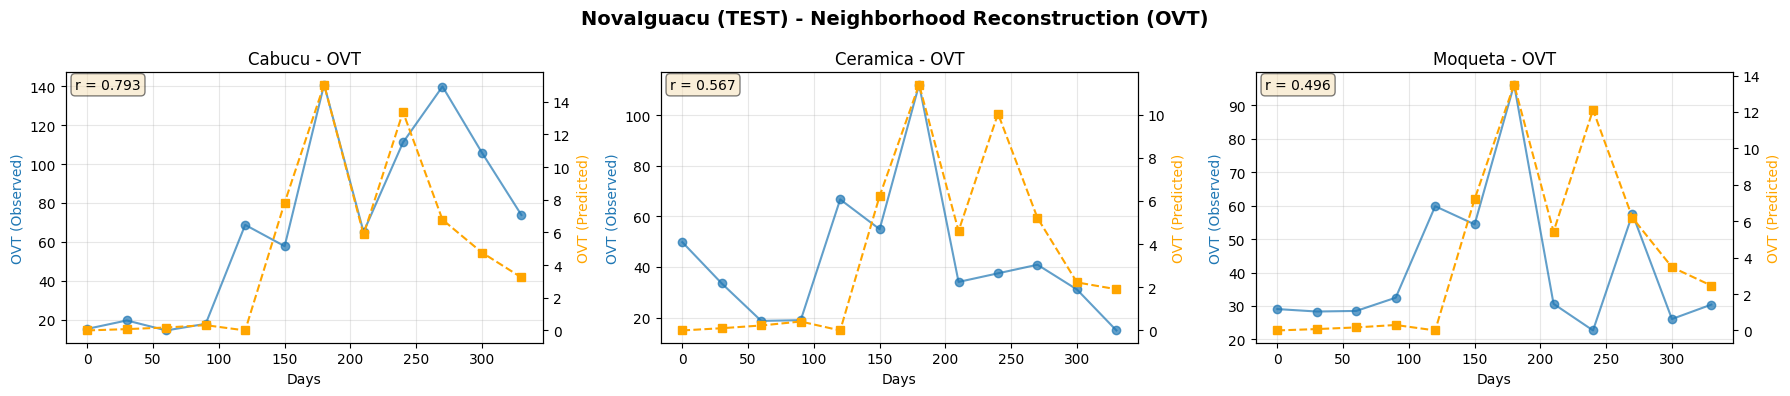

  Cabucu: Pearson r = 0.793
  Ceramica: Pearson r = 0.567
  Moqueta: Pearson r = 0.496
  Average: 0.619

Neighborhood Reconstruction: DuqueDeCaxias (TEST)
Computing terrain proportions...
  Bilac: [0, 3278, 31286, 147765]
  Primavera: [0, 25312, 17831, 139186]
  Saracuruna: [0, 14567, 25496, 142266]
Proportions matrix shape: (3, 4)


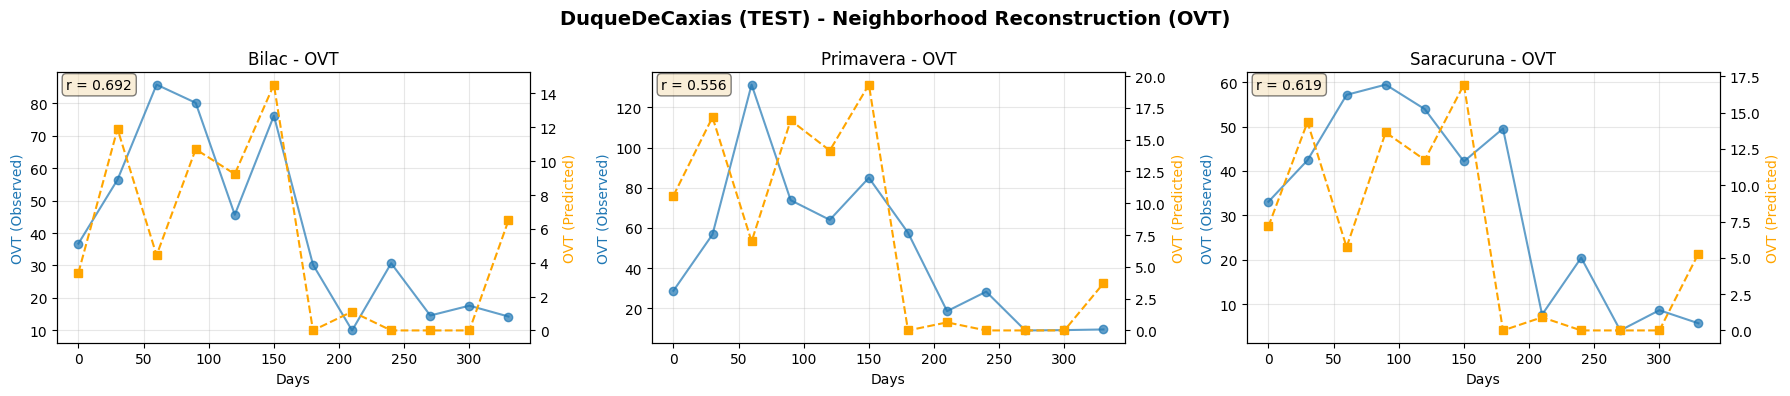

  Bilac: Pearson r = 0.692
  Primavera: Pearson r = 0.556
  Saracuruna: Pearson r = 0.619
  Average: 0.622


In [38]:
test_neigh_results = {}

for city in TEST_CITIES:
    if city not in test_results:
        continue

    print(f"\n{'='*50}")
    print(f"Neighborhood Reconstruction: {city} (TEST)")
    print(f"{'='*50}")

    cfg = CITY_CONFIG[city]
    csv_suffixes = cfg['csv_suffixes']
    neigh_names = cfg['neighborhoods']

    # Load raw neighborhood data
    df_raw = pd.read_csv(cfg['csv'])
    days_city = [i * 30 for i in range(len(df_raw))]

    # Compute terrain proportions
    print("Computing terrain proportions...")
    prop_matrix = get_proportions_matrix(city)
    print(f"Proportions matrix shape: {prop_matrix.shape}")

    # Get terrain-level predictions for this city
    tr = test_results[city]
    pred_park_ovt = tr['preds']['park']['ovt_pred']
    pred_house_ovt = tr['preds']['house']['ovt_pred']
    pred_street_ovt = tr['preds']['street']['ovt_pred']

    # Reconstruct
    reconstructed = reconstruct_neighborhoods(
        city, pred_park_ovt, pred_house_ovt, pred_street_ovt, prop_matrix
    )

    # Load observed neighborhood data
    obs_ovt = {}
    for i, (neigh, suffix) in enumerate(zip(neigh_names, csv_suffixes)):
        col = f'OVT_{suffix}'
        obs_ovt[neigh] = df_raw[col].ffill().bfill().values

    # Plot
    n_neigh = len(neigh_names)
    fig, axes = plt.subplots(1, n_neigh, figsize=(6 * n_neigh, 4))
    if n_neigh == 1:
        axes = [axes]

    corrs = []
    for i, neigh in enumerate(neigh_names):
        ax1 = axes[i]
        obs = obs_ovt[neigh]
        pred = reconstructed['OVT'][i]
        corr = safe_pearsonr(obs, pred)
        corrs.append(corr)

        ax1.plot(days_city, obs, 'o-', label='Observed', alpha=0.7)
        ax1.set_xlabel('Days')
        ax1.set_ylabel('OVT (Observed)', color='tab:blue')
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(days_city, pred, 's--', color='orange', label='Predicted')
        ax2.set_ylabel('OVT (Predicted)', color='orange')

        ax1.set_title(f'{neigh} - OVT')
        ax1.text(0.02, 0.98, f'r = {corr:.3f}', transform=ax1.transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    fig.suptitle(f'{city} (TEST) - Neighborhood Reconstruction (OVT)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    for neigh, corr in zip(neigh_names, corrs):
        print(f'  {neigh}: Pearson r = {corr:.3f}')
    print(f'  Average: {np.mean(corrs):.3f}')

    test_neigh_results[city] = {
        'neighborhoods': neigh_names,
        'corrs': corrs,
    }

In [39]:
# Final combined summary
print("=" * 70)
print("FINAL SUMMARY: Neighborhood Reconstruction (all cities)")
print("=" * 70)

all_neigh_rows = []
for city in CITIES:
    res = train_neigh_results[city]
    for neigh, corr in zip(res['neighborhoods'], res['corrs']):
        all_neigh_rows.append({'City': city, 'Set': 'TRAIN', 'Neighborhood': neigh, 'OVT_r': corr})

for city in TEST_CITIES:
    if city in test_neigh_results:
        res = test_neigh_results[city]
        for neigh, corr in zip(res['neighborhoods'], res['corrs']):
            all_neigh_rows.append({'City': city, 'Set': 'TEST', 'Neighborhood': neigh, 'OVT_r': corr})

all_neigh_df = pd.DataFrame(all_neigh_rows)
print(all_neigh_df.to_string(index=False, float_format='%.3f'))

train_avg = all_neigh_df[all_neigh_df['Set'] == 'TRAIN']['OVT_r'].mean()
test_avg = all_neigh_df[all_neigh_df['Set'] == 'TEST']['OVT_r'].mean()

print(f"\nTrain neighborhoods avg OVT r: {train_avg:.3f}")
print(f"Test neighborhoods avg OVT r:  {test_avg:.3f}")
print(f"Overall avg OVT r:             {all_neigh_df['OVT_r'].mean():.3f}")

FINAL SUMMARY: Neighborhood Reconstruction (all cities)
         City   Set  Neighborhood  OVT_r
   Parnamirim TRAIN         Areia  0.527
   Parnamirim TRAIN         Emaus  0.684
   Parnamirim TRAIN     Liberdade  0.590
     Santarem TRAIN   Jd_Santarem  0.492
     Santarem TRAIN     Republica  0.428
     Santarem TRAIN Santarenzinho  0.409
  CampoGrande TRAIN      Guanandi  0.344
  CampoGrande TRAIN      Planalto  0.403
  CampoGrande TRAIN       Carlota  0.209
   NovaIguacu  TEST        Cabucu  0.793
   NovaIguacu  TEST      Ceramica  0.567
   NovaIguacu  TEST       Moqueta  0.496
DuqueDeCaxias  TEST         Bilac  0.692
DuqueDeCaxias  TEST     Primavera  0.556
DuqueDeCaxias  TEST    Saracuruna  0.619

Train neighborhoods avg OVT r: 0.454
Test neighborhoods avg OVT r:  0.621
Overall avg OVT r:             0.521


In [40]:
#show the minimun and maximal temperature in each city:
print("\nTemperature ranges in each city:")
for city in CITIES + TEST_CITIES:
    if city in test_dfs:
        df = test_dfs[city]
    else:
        df = full_data[full_data['City'] == city]
    temp_min = df['Temperature'].min()
    temp_max = df['Temperature'].max()
    print(f"  {city}: {temp_min:.1f}﷿﷿C to {temp_max:.1f}﷿﷿C")
    


Temperature ranges in each city:
  Parnamirim: 24.5﷿﷿C to 27.9﷿﷿C
  Santarem: 25.4﷿﷿C to 29.5﷿﷿C
  CampoGrande: 12.6﷿﷿C to 22.3﷿﷿C
  NovaIguacu: 20.9﷿﷿C to 28.1﷿﷿C
  DuqueDeCaxias: 21.1﷿﷿C to 26.8﷿﷿C
